# Comparison of aviation climate models

In [1]:
import math
import numpy as np
import pandas as pd
import time
from pandas import read_csv
import matplotlib.pyplot as plt
from climate_models.fair_climate_model import background_species_quantities_function, species_fair_climate_model
from climate_models.climate_models import aviation_climate_model

## Parameters

In [2]:
scenario = "Historical"

In [3]:
commercial_aviation_historical_data_df = read_csv("climate_data/aviation_emissions_data.csv", delimiter=";")
commercial_aviation_historical_data = commercial_aviation_historical_data_df.values

if scenario == "Historical":
    years_data = commercial_aviation_historical_data[:80, 0]
    co2_emissions_data = commercial_aviation_historical_data[:80, 1]
    nox_emissions_data = commercial_aviation_historical_data[:80, 2]
    h2o_emissions_data = commercial_aviation_historical_data[:80, 3]
    soot_emissions_data = commercial_aviation_historical_data[:80, 4]
    sulfur_emissions_data = commercial_aviation_historical_data[:80, 5]
    distance_data = commercial_aviation_historical_data[:80, 6]
    
else:
    years_data = commercial_aviation_historical_data[:, 0]
    co2_emissions_data = commercial_aviation_historical_data[:, 1]
    nox_emissions_data = commercial_aviation_historical_data[:, 2]
    h2o_emissions_data = commercial_aviation_historical_data[:, 3]
    soot_emissions_data = commercial_aviation_historical_data[:, 4]
    sulfur_emissions_data = commercial_aviation_historical_data[:, 5]
    distance_data = commercial_aviation_historical_data[:, 6]

species_quantities = np.zeros((7, len(years_data)))

species_quantities[0] = co2_emissions_data * 1e9 # [Mt to kg]
species_quantities[1] = distance_data
species_quantities[2] = nox_emissions_data * 1e9 # [Mt to kg]
species_quantities[3] = nox_emissions_data * 1e9 # [Mt to kg]
species_quantities[4] = h2o_emissions_data * 1e9 # [Mt to kg]
species_quantities[5] = soot_emissions_data * 1e9 # [Mt to kg]
species_quantities[6] = sulfur_emissions_data * 1e9 # [Mt to kg]

if scenario == "Trend":
    pass
elif scenario == "Stabilisation":
    for i in range(0,7):
        for j in range(110, len(years_data)):
            species_quantities[i, j] = species_quantities[i, j-1] 
            
elif scenario == "Halt":
    for i in range(0,7):
        for j in range(110, len(years_data)):
            species_quantities[i, j] = 0  

start_year = int(years_data[0])
end_year = int(years_data[-1])

In [4]:
reference_temperature_data_df = read_csv("climate_data/reference_temperature_change_historic.csv", delimiter=";")
reference_temperature_data = reference_temperature_data_df.values
data_years = reference_temperature_data[:, 0]
data_temperature_grewe_curtech = reference_temperature_data[:, 1]
data_temperature_grewe_ecats = reference_temperature_data[:, 2]
data_temperature_klower = reference_temperature_data[:, 3]
data_temperature_klower_co2 = reference_temperature_data[:, 4]

In [5]:
background_species_quantities = background_species_quantities_function(start_year, end_year, rcp='RCP45')
sensitivity_erf_gwpstar = [0, 9.36e-13, 34.4e-12 * (14/46), -30.8e-12 * (14/46) * 0.77, 0.0052e-12, 100.7e-12, -19.9e-12]
sensitivity_erf_others = [0, 9.36e-13, 34.4e-12 * (14/46), -0.98e-9, 0.0052e-12, 100.7e-12, -19.9e-12]
ratio_erf_rf = [1, 0.42, 1.37, 1.18, 1, 1, 1]
efficacy_erf = [1, 1, 1, 1, 1, 1, 1]
tcre = 0.00045

species_settings_gwpstar = {"sensitivity_erf": sensitivity_erf_gwpstar, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}
species_settings_others = {"sensitivity_erf": sensitivity_erf_others, "ratio_erf_rf": ratio_erf_rf, "efficacy_erf": efficacy_erf}

model_settings_others = {"tcre": tcre}
model_settings_fair = {"background_species_quantities": background_species_quantities}

## Calculation

In [6]:
time1 = time.time()
gwpstar_climate_model = aviation_climate_model(start_year, end_year, "GWP*", species_quantities, species_settings_gwpstar, model_settings_others)
time2 = time.time()
lwe_climate_model = aviation_climate_model(start_year, end_year, "LWE", species_quantities, species_settings_others, model_settings_others)
time3 = time.time()
fair_climate_model = aviation_climate_model(start_year, end_year, "FaIR", species_quantities, species_settings_others, model_settings_fair)
time4 = time.time()
fair2_climate_model = aviation_climate_model(start_year, end_year, species_fair_climate_model, species_quantities, species_settings_others, model_settings_fair)
time5 = time.time()
print("GWP*:", time2-time1, "s")
print("LWE:", time3-time2 ,"s")
print("FaIR:", time4-time3, "s")
print("FaIR (manual):", time5-time4, "s")

The chosen climate model is directly provided or not available in AeroMAPS.
GWP*: 0.0165252685546875 s
LWE: 0.24938201904296875 s
FaIR: 0.9364175796508789 s
FaIR (manual): 1.5776655673980713 s


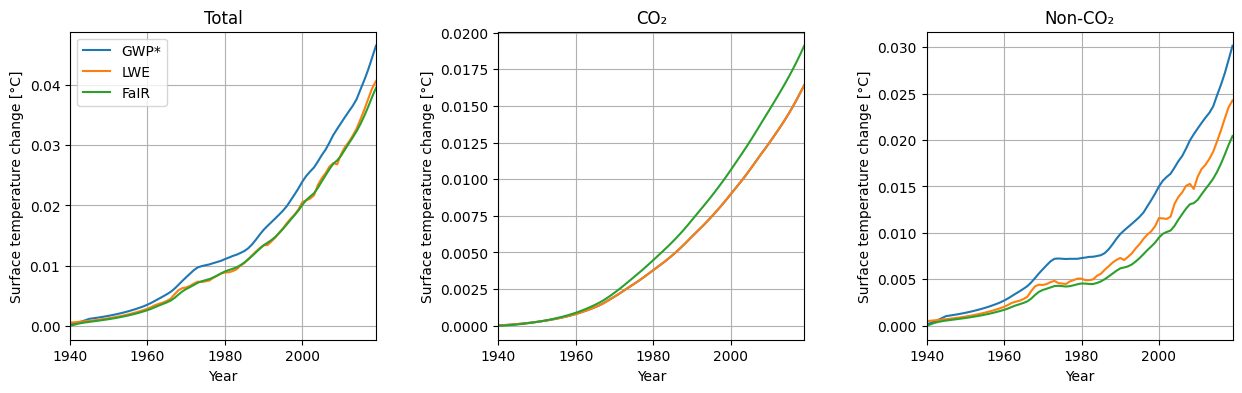

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

plt.subplots_adjust(wspace=0.4)

for i, ax in enumerate(axes.flat):
    if i == 0:
        ax.plot(years_data, gwpstar_climate_model[-1], label='GWP*')
        ax.plot(years_data, lwe_climate_model[-1], label='LWE')
        ax.plot(years_data, fair_climate_model[-1], label='FaIR')
        ax.legend()
        ax.grid()
        ax.set_title('Total')
    elif i == 1:
        ax.plot(years_data, gwpstar_climate_model[2], label='GWP*')
        ax.plot(years_data, lwe_climate_model[2], label='LWE')
        ax.plot(years_data, fair_climate_model[2], label='FaIR')
        ax.grid()
        ax.set_title('CO₂')
    else:
        ax.plot(years_data, gwpstar_climate_model[-4], label='GWP*')
        ax.plot(years_data, lwe_climate_model[-4], label='LWE')
        ax.plot(years_data, fair_climate_model[-4], label='FaIR')
        ax.grid()
        ax.set_title('Non-CO₂')
    
    ax.set_xlim(start_year,end_year)
    ax.set_xlabel('Year')
    ax.set_ylabel('Surface temperature change [°C]')


plt.show()

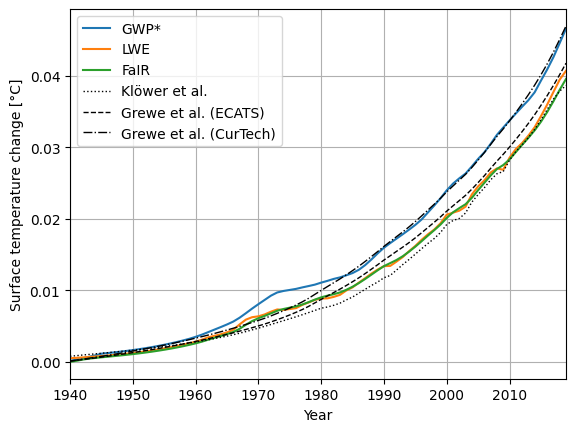

In [14]:
plt.plot(years_data, gwpstar_climate_model[-1], label='GWP*')
plt.plot(years_data, lwe_climate_model[-1], label='LWE')
plt.plot(years_data, fair_climate_model[-1], label='FaIR')
plt.plot(years_data, data_temperature_klower[0:2019-1940+1]/1000, label='Klöwer et al.', color='black', linestyle =":", linewidth=1)
plt.plot(years_data, data_temperature_grewe_ecats[0:2019-1940+1]/1000, label='Grewe et al. (ECATS)', color='black', linestyle ="--", linewidth=1)
plt.plot(years_data, data_temperature_grewe_curtech[0:2019-1940+1]/1000, label='Grewe et al. (CurTech)', color='black', linestyle ="-.", linewidth=1)
# plt.plot(years_data, lwe_climate_model[2], label='CO₂ only', color='black', linestyle ="-")

plt.legend()
plt.grid()
plt.xlim(1940,2019)
plt.xlabel('Year')
plt.ylabel('Surface temperature change [°C]')
plt.show()